In [130]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [131]:
# Read CSV files for each season
df_15_16 = pd.read_csv('Barcelona15:16.csv')
df_16_17 = pd.read_csv('Barcelona16:17.csv')
df_17_18 = pd.read_csv('Barcelona17:18.csv')
df_18_19 = pd.read_csv('Barcelona18:19.csv')
df_19_20 = pd.read_csv('Barcelona19:20.csv')
df_20_21 = pd.read_csv('Barcelona20:21.csv')
df_21_22 = pd.read_csv('Barcelona21:22.csv')
df_22_23 = pd.read_csv('Barcelona22:23.csv')
df_23_24 = pd.read_csv('Barcelona23:24.csv')

# Combine all dataframes into one
BarcaTen = pd.concat(
    [df_15_16, df_16_17, df_17_18, df_18_19, df_19_20, df_20_21, df_21_22, df_22_23, df_23_24],
    ignore_index=True
)
print(BarcaTen.head())

  Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3       Unnamed: 4 Unnamed: 5  \
0      Venue     Result         GF         GA         Opponent       Poss   
1       Away          W          1          0    Athletic Club         67   
2       Home          W          1          0           Málaga         75   
3       Away          W          2          1  Atlético Madrid         69   
4       Home          W          4          1          Levante         70   

   Unnamed: 6      Unnamed: 7 Unnamed: 8     Unnamed: 9  ...  GF  GA  \
0  Attendance         Captain  Formation  Opp Formation  ... NaN NaN   
1      44,737      Dani Alves      4-3-3        4-2-3-1  ... NaN NaN   
2      80,812  Andrés Iniesta      4-3-3          4-4-2  ... NaN NaN   
3      53,491  Andrés Iniesta      4-3-3          4-4-2  ... NaN NaN   
4      76,013    Lionel Messi    4-2-3-1          5-3-2  ... NaN NaN   

   Opponent  Poss Attendance  Captain Formation Opp Formation  xG xGA  
0       NaN   NaN        NaN    

In [132]:
# Remove unnecessary unnamed index columns
BarcaTen = BarcaTen.loc[:, ~BarcaTen.columns.str.contains('^Unnamed')]
print("Removing unnecessary unnamed index columns...")

# Replace '?' with NaN and drop missing values
BarcaTen.replace('?', pd.NA, inplace=True)
BarcaTen.dropna(inplace=True)
print(BarcaTen.isnull().sum())

Removing unnecessary unnamed index columns...
Venue            0
Result           0
GF               0
GA               0
Opponent         0
Poss             0
Attendance       0
Captain          0
Formation        0
Opp Formation    0
xG               0
xGA              0
dtype: int64


In [133]:
BarcaTen['Attendance'] = BarcaTen['Attendance'].astype(str).str.replace(',', '').replace('?', pd.NA)
BarcaTen['Attendance'] = pd.to_numeric(BarcaTen['Attendance'], errors='coerce')
BarcaTen['Attendance'].fillna(0, inplace=True) 

In [134]:
# Convert specific columns to numeric (handling errors)
numeric_cols = ['GF', 'GA', 'xG', 'xGA', 'Poss', 'Attendance']
BarcaTen[numeric_cols] = BarcaTen[numeric_cols].apply(pd.to_numeric, errors='coerce')
print(BarcaTen.dtypes)

Venue             object
Result            object
GF               float64
GA               float64
Opponent          object
Poss             float64
Attendance         int64
Captain           object
Formation         object
Opp Formation     object
xG               float64
xGA              float64
dtype: object


In [135]:
# Normalize 'xG', 'xGA', and 'Poss' using Min-Max scaling
scaler = MinMaxScaler()
BarcaTen[['xG', 'xGA', 'Poss']] = scaler.fit_transform(BarcaTen[['xG', 'xGA', 'Poss']])
print(BarcaTen.head())

   Venue Result   GF   GA  Opponent      Poss  Attendance         Captain  \
75  Home      W  2.0  0.0     Betis  0.459459       56480    Lionel Messi   
76  Away      W  2.0  0.0    Alavés  0.783784       19356  Andrés Iniesta   
77  Home      W  5.0  0.0  Espanyol  0.864865       72857  Andrés Iniesta   
78  Away      W  2.0  1.0    Getafe  0.702703       15164  Andrés Iniesta   
79  Home      W  6.0  1.0     Eibar  0.459459       51645  Andrés Iniesta   

   Formation Opp Formation        xG       xGA  
75   4-4-1-1       4-1-4-1  0.166667  0.027778  
76     4-3-3         4-5-1  0.425926  0.250000  
77     4-4-2         4-4-2  0.907407  0.194444  
78     4-3-3       4-2-3-1  0.037037  0.277778  
79     4-3-3       4-2-3-1  0.407407  0.361111  


In [136]:
# Keep Venue and Formation columns for grouping before encoding
venue_data = BarcaTen[['Venue', 'GF', 'GA', 'xG', 'xGA']]
formation_data = BarcaTen[['Formation', 'GF', 'GA', 'xG', 'xGA']]

# Convert categorical variables to dummy/indicator variables
BarcaTen = pd.get_dummies(BarcaTen, columns=['Venue', 'Result', 'Formation', 'Opp Formation'], drop_first=True)
print(BarcaTen.head())

     GF   GA  Opponent      Poss  Attendance         Captain        xG  \
75  2.0  0.0     Betis  0.459459       56480    Lionel Messi  0.166667   
76  2.0  0.0    Alavés  0.783784       19356  Andrés Iniesta  0.425926   
77  5.0  0.0  Espanyol  0.864865       72857  Andrés Iniesta  0.907407   
78  2.0  1.0    Getafe  0.702703       15164  Andrés Iniesta  0.037037   
79  6.0  1.0     Eibar  0.459459       51645  Andrés Iniesta  0.407407   

         xGA  Venue_Home  Result_L  ...  Opp Formation_4-1-4-1  \
75  0.027778        True     False  ...                   True   
76  0.250000       False     False  ...                  False   
77  0.194444        True     False  ...                  False   
78  0.277778       False     False  ...                  False   
79  0.361111        True     False  ...                  False   

    Opp Formation_4-2-3-1  Opp Formation_4-2-4-0  Opp Formation_4-3-1-2  \
75                  False                  False                  False   
76      

In [137]:
BarcaTen['Goal_Difference'] = BarcaTen['GF'] - BarcaTen['GA']
BarcaTen['Total_Goals'] = BarcaTen['GF'] + BarcaTen['GA']
print(BarcaTen.head())

     GF   GA  Opponent      Poss  Attendance         Captain        xG  \
75  2.0  0.0     Betis  0.459459       56480    Lionel Messi  0.166667   
76  2.0  0.0    Alavés  0.783784       19356  Andrés Iniesta  0.425926   
77  5.0  0.0  Espanyol  0.864865       72857  Andrés Iniesta  0.907407   
78  2.0  1.0    Getafe  0.702703       15164  Andrés Iniesta  0.037037   
79  6.0  1.0     Eibar  0.459459       51645  Andrés Iniesta  0.407407   

         xGA  Venue_Home  Result_L  ...  Opp Formation_4-2-4-0  \
75  0.027778        True     False  ...                  False   
76  0.250000       False     False  ...                  False   
77  0.194444        True     False  ...                  False   
78  0.277778       False     False  ...                  False   
79  0.361111        True     False  ...                  False   

    Opp Formation_4-3-1-2  Opp Formation_4-3-3  Opp Formation_4-4-1-1  \
75                  False                False                  False   
76          

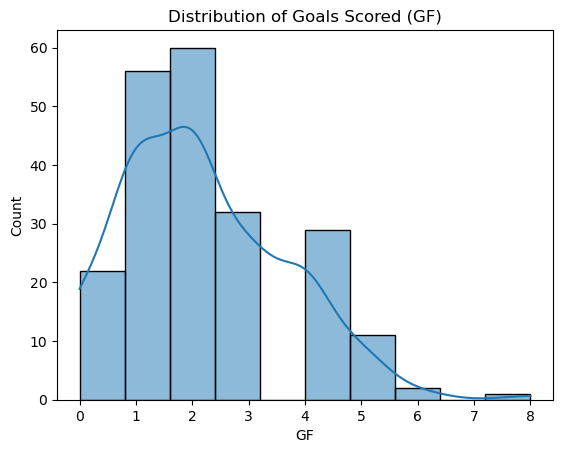

In [138]:
# Plot 1: Distribution of Goals Scored (GF)
sns.histplot(BarcaTen['GF'], bins=10, kde=True)
plt.title('Distribution of Goals Scored (GF)')
plt.show()

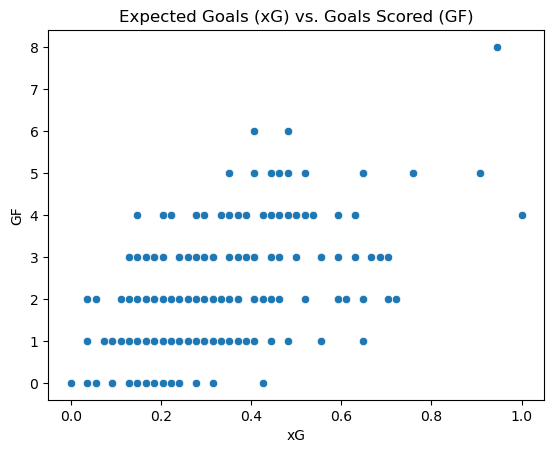

In [139]:
# Plot 2: Scatter plot showing the relationship between Expected Goals (xG) and Goals Scored (GF)
sns.scatterplot(x='xG', y='GF', data=BarcaTen)
plt.title('Expected Goals (xG) vs. Goals Scored (GF)')
plt.show()

In [140]:
# Correlation Analysis: Select only numeric columns
numeric_data = BarcaTen.select_dtypes(include=['number'])

# Calculate correlation matrix
corr_matrix = numeric_data.corr()

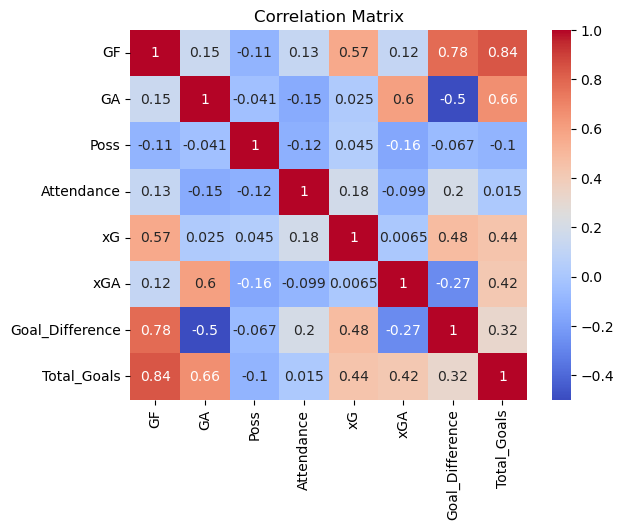

In [141]:
# Plot 3: Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [142]:
# Group by opponent and calculate average goals scored and conceded
opponent_stats = BarcaTen.groupby('Opponent').agg({
    'GF': 'mean',
    'GA': 'mean',
    'xG': 'mean',
    'xGA': 'mean'
}).reset_index()

# Sort by average goals scored
opponent_stats_sorted = opponent_stats.sort_values(by='GF', ascending=False)

# Display the top 10 opponents by average goals scored
print(opponent_stats_sorted.head(10))

      Opponent        GF        GA        xG       xGA
14   La Coruña  4.000000  1.000000  0.814815  0.361111
13      Huesca  4.000000  1.000000  0.555556  0.263889
7        Eibar  3.500000  0.500000  0.358025  0.240741
4        Betis  3.250000  1.166667  0.376543  0.212963
8        Elche  3.000000  0.750000  0.537037  0.222222
27  Villarreal  2.900000  1.500000  0.385185  0.338889
17     Levante  2.750000  1.375000  0.418981  0.447917
24     Sevilla  2.500000  0.800000  0.388889  0.350000
9     Espanyol  2.444444  0.888889  0.384774  0.283951
16     Leganés  2.400000  1.000000  0.292593  0.250000


In [143]:
# Group by venue (using original data) and calculate averages
venue_stats = venue_data.groupby('Venue').agg({
    'GF': 'mean',
    'GA': 'mean',
    'xG': 'mean',
    'xGA': 'mean'
}).reset_index()

# Display the results
print(venue_stats)

  Venue        GF        GA        xG       xGA
0  Away  1.878505  1.056075  0.274836  0.309190
1  Home  2.471698  0.773585  0.375437  0.265985


In [144]:
# Group by formation (using original data) and calculate averages
formation_stats = formation_data.groupby('Formation').agg({
    'GF': 'mean',
    'GA': 'mean',
    'xG': 'mean',
    'xGA': 'mean'
}).reset_index()

print(formation_stats)

     Formation        GF        GA        xG       xGA
0      3-1-4-2  0.333333  0.666667  0.172840  0.148148
1      3-2-4-1  4.000000  1.000000  0.351852  0.222222
2      3-3-3-1  2.000000  2.000000  0.129630  0.083333
3      3-4-1-2  1.000000  1.000000  0.212963  0.277778
4        3-4-3  2.000000  0.000000  0.592593  0.305556
5       3-4-3◆  3.000000  2.000000  0.462963  0.361111
6        3-5-2  5.000000  0.000000  0.648148  0.277778
7   4-1-2-1-2◆  2.333333  1.333333  0.444444  0.342593
8      4-1-4-1  2.000000  0.000000  0.148148  0.305556
9      4-2-3-1  1.923077  1.076923  0.290598  0.361111
10       4-3-3  2.163522  0.962264  0.321919  0.294549
11     4-4-1-1  2.000000  0.000000  0.166667  0.027778
12       4-4-2  2.461538  0.576923  0.363960  0.236111


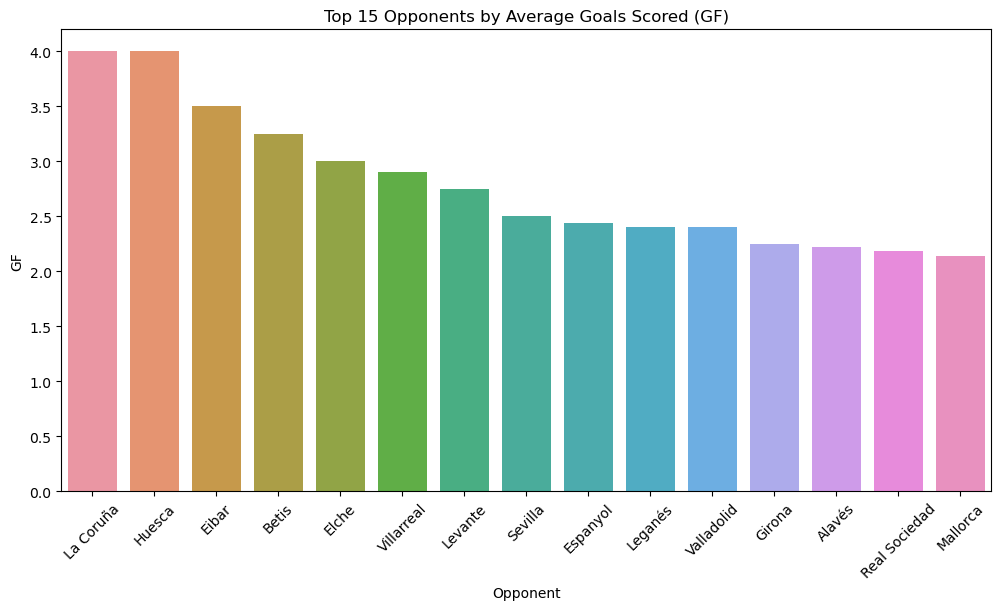

In [145]:
# Plot 4: Top 15 Opponents by Average Goals Scored (GF)
plt.figure(figsize=(12, 6))
sns.barplot(x='Opponent', y='GF', data=opponent_stats_sorted.head(15))
plt.title('Top 15 Opponents by Average Goals Scored (GF)')
plt.xticks(rotation=45)
plt.show()

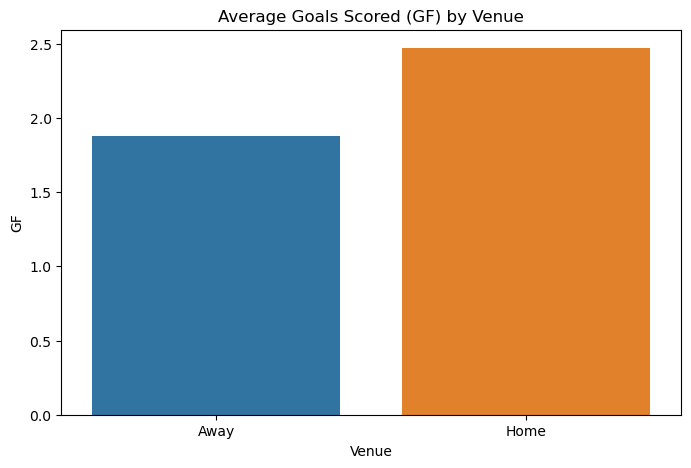

In [146]:
# Plot 5: Home vs. Away Performance
plt.figure(figsize=(8, 5))
sns.barplot(x='Venue', y='GF', data=venue_stats)
plt.title('Average Goals Scored (GF) by Venue')
plt.show()

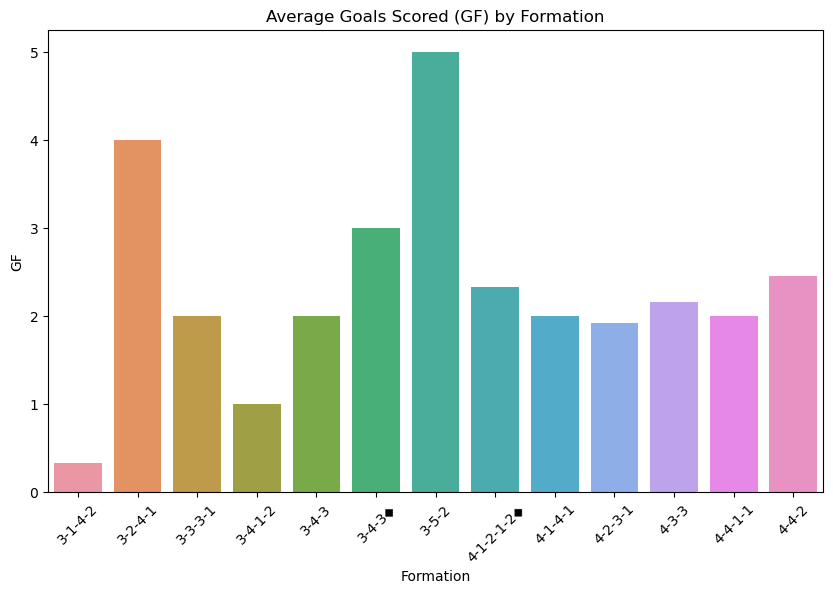

In [147]:
# Plot 6: Formation Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Formation', y='GF', data=formation_stats)
plt.title('Average Goals Scored (GF) by Formation')
plt.xticks(rotation=45)
plt.show()

In [148]:
# Define features (X) and target (y)
X = BarcaTen[['xG', 'xGA', 'Poss', 'Venue_Home', 'Formation_4-3-3', 'Total_Goals']]
y = BarcaTen['Result_W']  # Predict whether Barcelona wins (1) or not (0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the shapes of the training and testing sets
print(X_train.shape, X_test.shape)

(170, 6) (43, 6)


In [149]:
# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train_ = imputer.fit_transform(X_train)
X_test_ = imputer.transform(X_test)

# Convert the result back to a DataFrame (optional)
X_train_ = pd.DataFrame(X_train_, columns=X_train.columns)
X_test_ = pd.DataFrame(X_test_, columns=X_test.columns)

In [150]:
# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model on the imputed training data
model.fit(X_train_, y_train)

# Make predictions on the imputed test data
y_pred = model.predict(X_test_)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.77
              precision    recall  f1-score   support

       False       1.00      0.29      0.44        14
        True       0.74      1.00      0.85        29

    accuracy                           0.77        43
   macro avg       0.87      0.64      0.65        43
weighted avg       0.83      0.77      0.72        43



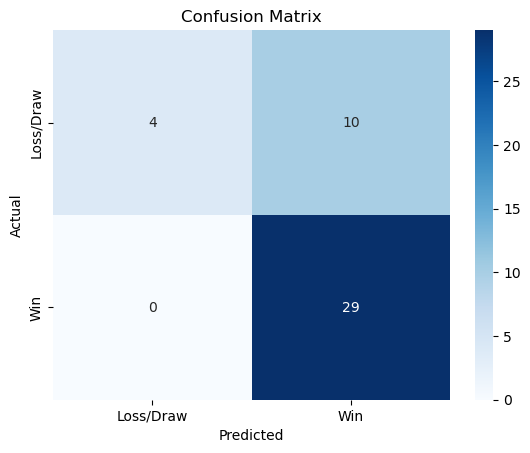

In [151]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss/Draw', 'Win'], yticklabels=['Loss/Draw', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [152]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')

# Display classification report
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.77
              precision    recall  f1-score   support

       False       0.67      0.57      0.62        14
        True       0.81      0.86      0.83        29

    accuracy                           0.77        43
   macro avg       0.74      0.72      0.72        43
weighted avg       0.76      0.77      0.76        43



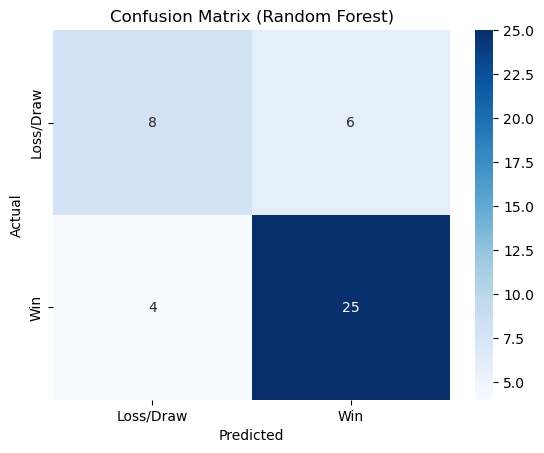

In [153]:
# Plot confusion matrix RF
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss/Draw', 'Win'], yticklabels=['Loss/Draw', 'Win'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [154]:
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
gb_model.fit(X_train_, y_train)

# Make predictions on the test data
y_pred_gb = gb_model.predict(X_test_)

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')

# Display classification report
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.84
              precision    recall  f1-score   support

       False       0.77      0.71      0.74        14
        True       0.87      0.90      0.88        29

    accuracy                           0.84        43
   macro avg       0.82      0.81      0.81        43
weighted avg       0.83      0.84      0.84        43



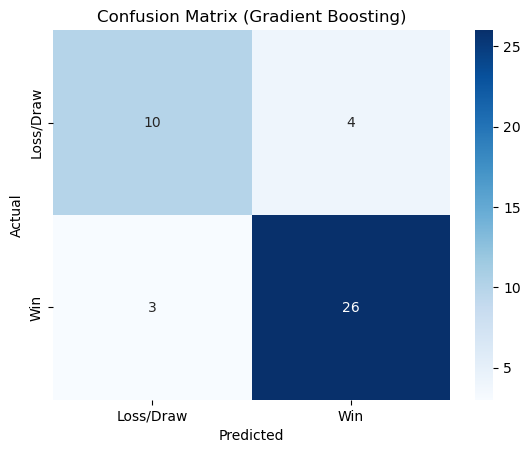

In [155]:
# Plot confusion matrix GB
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss/Draw', 'Win'], yticklabels=['Loss/Draw', 'Win'])
plt.title('Confusion Matrix (Gradient Boosting)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [156]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

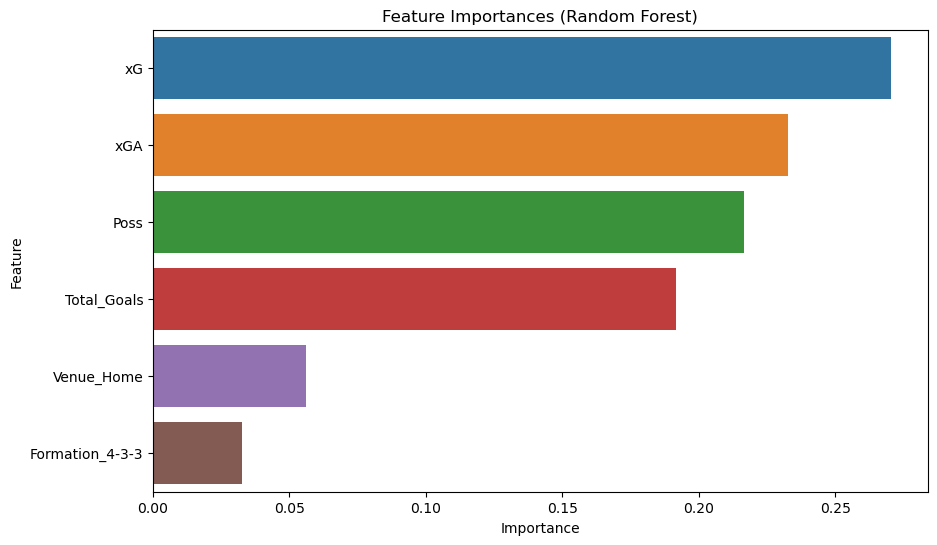

In [157]:
# Plot feature importances RF
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances (Random Forest)')
plt.show()

In [158]:
# Get feature importances
feature_importances_gb = gb_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_gb_df = pd.DataFrame({
    'Feature': X_train_.columns,
    'Importance': feature_importances_gb
}).sort_values(by='Importance', ascending=False)

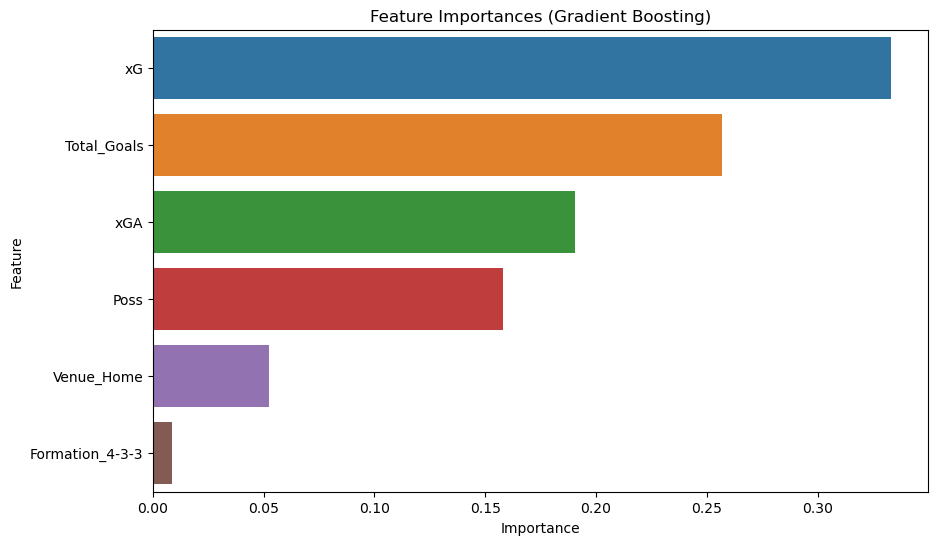

In [159]:
# Plot feature importances GB
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_gb_df)
plt.title('Feature Importances (Gradient Boosting)')
plt.show()

In [160]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'Best Model Accuracy: {accuracy_best:.2f}')
print(f'Best Parameters: {best_params}')

# Display classification report
print(classification_report(y_test, y_pred_best))


Best Model Accuracy: 0.81
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

       False       0.75      0.64      0.69        14
        True       0.84      0.90      0.87        29

    accuracy                           0.81        43
   macro avg       0.79      0.77      0.78        43
weighted avg       0.81      0.81      0.81        43



In [161]:
# Check correlation with the target variable
print(BarcaTen[['Goal_Difference', 'Total_Goals', 'Result_W']].corr())

                 Goal_Difference  Total_Goals  Result_W
Goal_Difference         1.000000     0.320731  0.747103
Total_Goals             0.320731     1.000000  0.105304
Result_W                0.747103     0.105304  1.000000
